# Models

Models are key elements of the control and estimation algorithms in Sia.  They are used to predict how the system state $x \in \mathbb{R}^n$ is expected to change or how it is observed.  The models can be designed from first principles or learned from data.  There are two flavors of models used in the control and estimaton algorithms in Sia.

1. The **dynamics model** predicts $p(x_{k+1} | x_k, u_k)$, i.e. the statistical propogation from state $x_k$ to $x_{k+1}$ given an action $u_k$.  In Sia, dynamics models inherit from the `sia.DynamicsModel`.  Time can be addressed in two ways.
    - *Discrete time.*  In this case the user provides the equation above which makes implicit assumptions about the time step.  All estimation and control algorithms in Sia operate on the discrete model representation.
    - *Continuous time.*  In this case the user provides an equation $p(\dot{x} | x, u)$ and a timestep $\Delta t$.  The model is discretized using Runge Kutta integration.
  
2. The **measurement model** predicts $p(y | x)$, i.e. the statistical measurement $y$ given a state $x$.  In Sia, measurement models inherit from `sia.MeasurementModel`.

Some of the algorithms in Sia use model gradients.  Linearizable models inherit from two virtual base classes `sia.LinearizableDynamics` and `sia.LinearizableMeasurement` that provide additional access to the Jacobians needed for gradient-based algorithms.  By default, central difference is used, but the gradient functions can be specialized.

**References**

1. [S. Thrun, W. Burard, and D. Fox, Probabilistic Robotics, MIT Press, 2004.](https://docs.ufpr.br/~danielsantos/ProbabilisticRobotics.pdf)

2. [J. L. Crassidis and J. L. Junkins, Optimal Estimation of Dynamic Systems, 2nd Ed., CRC Press, 2004.](http://ancs.eng.buffalo.edu/index.php/Optimal_Estimation_of_Dynamic_Systems_2nd_Edition)

In [1]:
# Import the libSIA python bindings and numpy
import pysia as sia
import numpy as np

# Import plotting helpers
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# Set the generator instance seed for repeatability
generator = sia.Generator.instance()
generator.seed(1)

## Linear Gaussian Systems
Linear Gaussian systems make linear assumptions about the dynamics and measurement equations and assume that zero-mean uncorrelated Gaussian noise is added linearly.

### Discrete time
`sia.LinearGaussianDynamics` implements the linear dynamics equation

$$
x_{k+1} = F x_k + G u_k + w_k,\quad w_k \sim \mathcal{N}(0, Q)
$$

`sia.LinearGaussianMeasurement` implements the linear measurement equation

$$
y_k = H x_k + v_k,\quad v_k \sim \mathcal{N}(0, R)
$$

### Continuous Time
`sia.LinearGaussianDynamicsCT` implements the linear dynamics equation

$$
\dot{x} = A x + B u + w,\quad w \sim \mathcal{N}(0, Q_{psd})
$$

`sia.LinearGaussianMeasurementCT` implements the linear measurement equation

$$
y = H x + v,\quad v \sim \mathcal{N}(0, R_{psd})
$$

**A note on discretization.** When converting between discrete time and continuous time, the noise matrices represent different values.  In discrete time, $Q,R$ represent covariance matrices which have an implicit time step, while $Q_{psd},R_{psd}$ matrices represent power spectral densities (PSD) which are time invariant.  `sia` uses first-order Taylor series expansions to convert between covariance and power spectral density.

$$
Q = Q_{psd} \Delta t
$$

$$
R = \frac{R_{psd}}{\Delta t}
$$

Below is an example that simulates multiple trajectories for a discrete time Linear/Gaussian system.

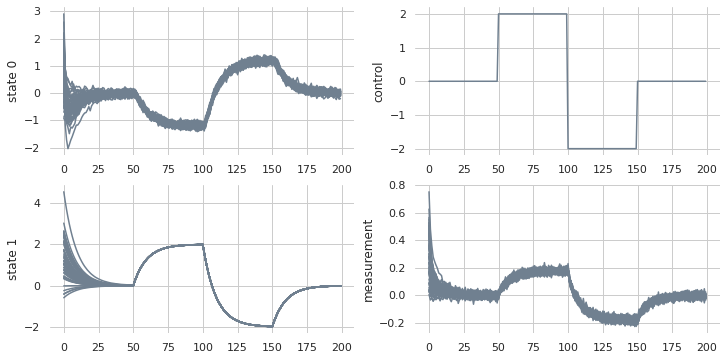

In [2]:
# Create a linear Gaussian system
linear_dynamics = sia.LinearGaussianDynamics(
    F=np.array([[0.5, -0.3], [0, 0.9]]),
    G=np.array([[0], [0.1]]),
    Q=np.diag([5e-3, 1e-6])
)
linear_measurement = sia.LinearGaussianMeasurement(
    H=np.array([[0.1, 0.15]]),
    R=np.array([[2e-4]])
)

# Create a positive/negative step command
nt = 200
u = np.zeros((1, nt))
u[0, 50:] = 2
u[0, 100:] = -2
u[0, 150:] = 0

# Create an initial state distribution
belief = sia.Gaussian(np.ones(2), np.identity(2))

# Simulate the system with noise for the input vector for N trials
N = 50
x = np.zeros((2, nt, N))
y = np.zeros((1, nt, N))
for i in range(N):
    # Run the simulation for the i^th sample
    x[:, 0, i] = belief.sample()
    y[:, 0, i] = linear_measurement.measurement(x[:, 0, i]).sample()
    for k in range(nt-1):
        x[:, k+1, i] = linear_dynamics.dynamics(x[:, k, i], u[:, k]).sample()
        y[:, k+1, i] = linear_measurement.measurement(x[:, k+1, i]).sample()

# Plot
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
sns.despine(f, left=True, bottom=True)
ax[0, 0].set_ylabel("state 0")
ax[1, 0].set_ylabel("state 1")
ax[0, 1].set_ylabel("control")
ax[1, 1].set_ylabel("measurement")
ax[0, 0].plot(x[0, :, :], color="slategray")
ax[1, 0].plot(x[1, :, :], color="slategray")
ax[0, 1].plot(u[0, :], color="slategray")
ax[1, 1].plot(y[0, :, :], color="slategray");

## Nonlinear Gaussian Systems
Nonlinear Gaussian systems relax the linear assumptions about the dynamics and measurement equations, but still assume that zero-mean uncorrelated Gaussian noise is added linearly.

### Discrete time
`sia.NonlinearGaussianDynamics` implements the dynamics equation

$$
x_k = f(x_{k-1}, u_k) + w,\quad w \sim \mathcal{N}(0, Q)
$$

`sia.NonlinearGaussianMeasurement` implements the measurement equation

$$
y = h(x) + v,\quad v \sim \mathcal{N}(0, R)
$$

### Continuous Time
`sia.NonlinearGaussianDynamicsCT` implements the dynamics equation

$$
\dot{x} = f(x, u) + C w,\quad w \sim \mathcal{N}(0, Q_{psd})
$$

`sia.NonlinearGaussianMeasurementCT` implements the measurement equation

$$
y = h(x) + v,\quad v \sim \mathcal{N}(0, R_{psd})
$$

Conversion between covariance and power spectral density (PSD) from linear systems applies to the nonlinear Gaussian case.  Below is an example that simulates multiple trajectories for a continuous time Nonlinear Gaussian system.

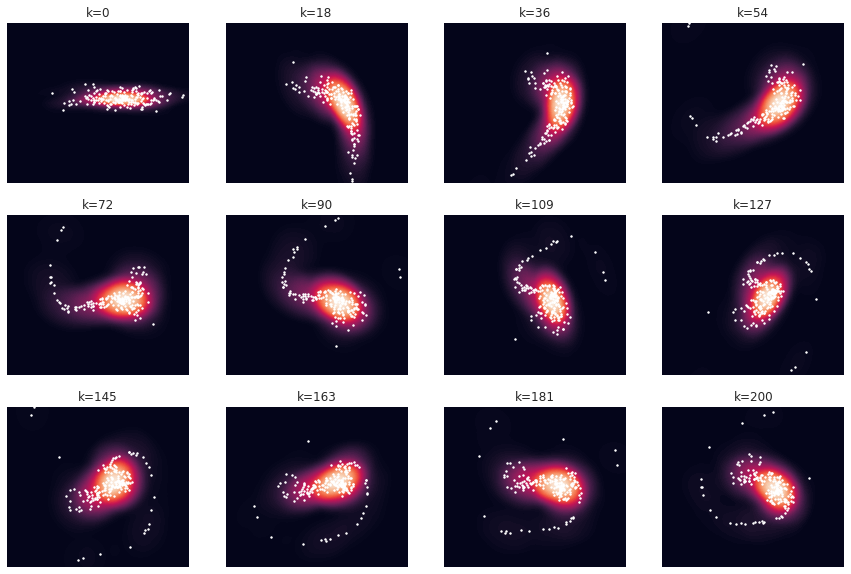

In [3]:
# Sample rate (s)
dt = 0.01

# Initialize dynamics for the Duffing oscillator
dynamics = lambda x, u: np.array([
    x[1],
    -0.02 * x[1] - x[0] - 5 * x[0]**3 + 8 * u[0]
])

nonlinear_dynamics = sia.NonlinearGaussianDynamicsCT(
    dynamics=dynamics,
    Qpsd=np.diag([1e-6, 1e-2]),
    dt=dt
)

# Observe the velocity state
measurement = lambda x: np.array([x[1]])

nonlinear_measurement = sia.NonlinearGaussianMeasurementCT(
    measurement=measurement,
    Rpsd=np.array([[1e-4]]),
    dt=dt
)

# Create a sinusoidal control
t = np.arange(0, 2+dt, dt)
nt = len(t)
u = np.cos(0.5 * t)
u = np.reshape(u, (1, nt))

# Create an initial state distribution
belief = sia.Gaussian(np.ones(2), np.identity(2))

# Simulate the system with noise for the input vector for N trials
N = 200
x = np.zeros((2, nt, N))
y = np.zeros((1, nt, N))
for i in range(N):
    # Run the simulation for the i^th sample
    x[:, 0, i] = belief.sample()
    y[:, 0, i] = nonlinear_measurement.measurement(x[:, 0, i]).sample()
    for k in range(nt-1):
        x[:, k+1, i] = nonlinear_dynamics.dynamics(x[:, k, i], u[:, k]).sample()
        y[:, k+1, i] = nonlinear_measurement.measurement(x[:, k+1, i]).sample()

# Plot the states at different snapshots in time
indices = np.linspace(0, len(t)-1, 12).astype(int)
f, ax = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
xx, yy = np.meshgrid(np.linspace(-4, 4, 51), np.linspace(-15, 15, 51))
ax = ax.flat
sns.despine(f, left=True, bottom=True)
for i in range(len(indices)):
    # Retrieve the samples at snapshot index
    k = indices[i]
        
    # Create a kernel density from the samples for the trajectory
    dist = sia.KernelDensity(x[:, k, :], np.ones(N) / N,
                             type=sia.KernelDensity.EPANECHNIKOV, bandwidth_scaling=3)
    prob = np.exp(sia.logProb2d(dist, xx.flatten(), yy.flatten()))
    ax[i].contourf(xx, yy, np.reshape(prob, xx.shape), levels=100)
    ax[i].scatter(x[0, k, :], x[1, k, :], s=2, color="white")
    ax[i].set_xlim([-4, 4])
    ax[i].set_ylim([-15, 15])
    ax[i].axis("off")
    ax[i].set_title("k={}".format(k))